# Detectando Niveles Jugables en Zelda

In [343]:
#### PACKAGE IMPORTS ####

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import numpy as np


### Cargar el dataset y procesar los datos

Found 1434 images belonging to 2 classes.
Found 408 images belonging to 2 classes.
Found 206 images belonging to 2 classes.


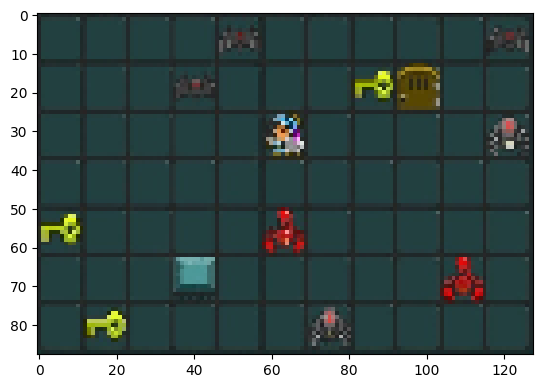

In [31]:
# Rutas a los directorios de entrenamiento y prueba
train_dir = 'dataset/train'
test_dir = 'dataset/test'
val_dir = 'dataset/val'

# Crear generadores de imágenes para entrenamiento y validación
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32
TARGET_SIZE = (88, 128)
EPOCHS = 10

# Cargar las imágenes de entrenamiento y prueba
train_generator = train_datagen.flow_from_directory(
  directory=train_dir,
  target_size=TARGET_SIZE,
  batch_size=BATCH_SIZE,
  class_mode='binary'
)

plt.imshow(train_generator[0][0][0])


test_generator = test_datagen.flow_from_directory(
  directory=test_dir,
  target_size=TARGET_SIZE,
  batch_size=BATCH_SIZE,
  class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
  directory=val_dir,
  target_size=TARGET_SIZE,
  batch_size=BATCH_SIZE,
  class_mode='binary'
)

In [32]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(88, 128, 3)),
    MaxPooling2D((2, 2), strides=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=(2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), strides=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization to prevent overfitting
    Dense(1, activation='sigmoid')  # Using sigmoid activation for binary classification
])

# Compilar el modelo
model.compile(optimizer= 'adam',loss= 'binary_crossentropy', metrics = ['accuracy'] )

/Users/paulina/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [35]:
# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=25,
    batch_size=10,
    validation_data=val_generator,
)

model.summary()

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_generator)
print('Precisión en el conjunto de prueba:', test_acc)

model.save("pau.keras")


Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.8005 - loss: 0.3995 - val_accuracy: 0.8155 - val_loss: 0.3774
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.8164 - loss: 0.3834 - val_accuracy: 0.8155 - val_loss: 0.3671
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.8043 - loss: 0.3974 - val_accuracy: 0.8252 - val_loss: 0.3831
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.8334 - loss: 0.3683 - val_accuracy: 0.8155 - val_loss: 0.4169
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 226ms/step - accuracy: 0.8062 - loss: 0.3987 - val_accuracy: 0.8592 - val_loss: 0.3571
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - accuracy: 0.8354 - loss: 0.3575 - val_accuracy: 0.8155 - val_loss: 0.3522
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 269ms/step - accuracy: 0.8344 - loss: 0.3375 - val_accuracy: 0.8398 - val_loss: 0.3109
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.8571 - loss: 0.3351 - val_accu

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 88, 128, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 44, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 44, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 22, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 22, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 11, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 11, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 5, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 5, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 2, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,000,261 (41.96 MB)

 Trainable params: 3,666,753 (13.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,333,508 (27.98 MB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9253 - loss: 0.2478
Precisión en el conjunto de prueba: 0.938725471496582


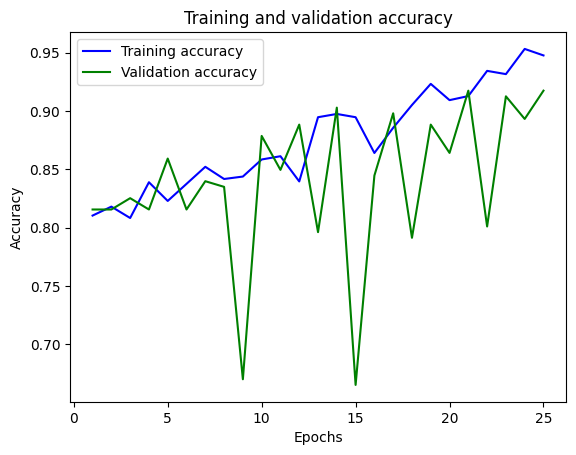

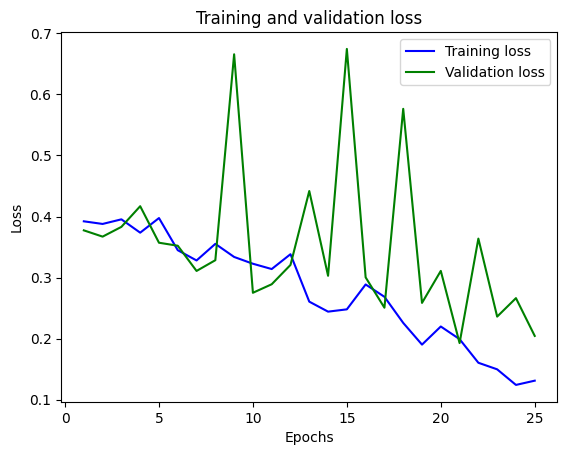

In [36]:
# Obtener accuracy y loss de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(acc)+1)

# Graficar accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

# Graficar loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Evaluación del modelo
Aquí se realizan los cálculos para realizar la matriz de confusión. 

Accuracy: 0.9387254901960784
Loss: 0.98289114
True positive rate: 0.945273631840796
False positive rate: 0.06763285024154589
Precisión: 0.9313725490196079
Sensibilidad (Recall): 0.945273631840796
Puntuación F1: 0.9382716049382716


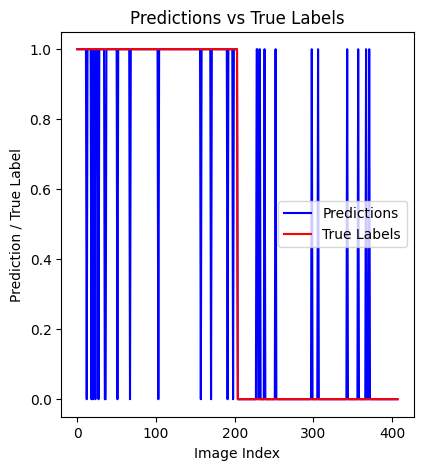

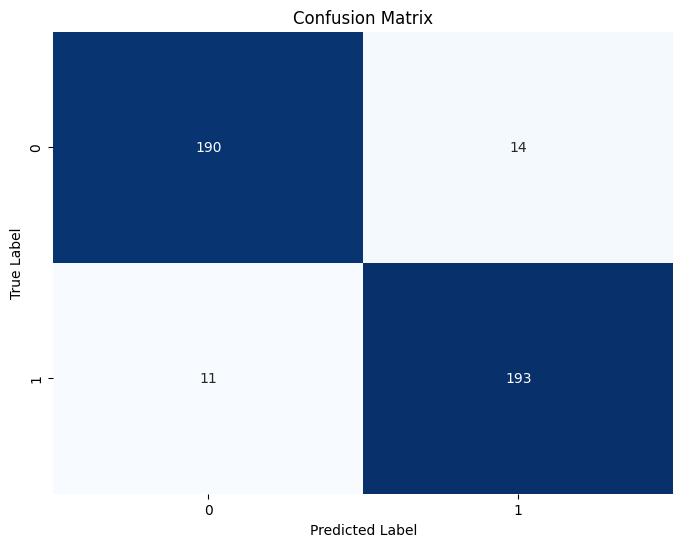

In [37]:
def check_manually(directory):
  file_predictions = []

  for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
      img_path = os.path.join(directory, filename)
      img = tf.keras.preprocessing.image.load_img(img_path, target_size=TARGET_SIZE)
      img_tensor = tf.keras.preprocessing.image.img_to_array(img)
      img_tensor = np.expand_dims(img_tensor, axis = 0)
      img_tensor /= 255.
      confidence = model.predict(img_tensor,  verbose = 0)
      file_predictions.append((confidence < 0.5).astype("int32"))

  return file_predictions

# Get the predictions for the test set
playable_predictions = check_manually(test_dir + '/playable')
unplayable_predictions = check_manually(test_dir + '/unplayable')

true_labels = np.array([1.0] * len(playable_predictions) + [0.0] * len(unplayable_predictions), dtype=np.float32)
predictions = np.concatenate([playable_predictions, unplayable_predictions]).flatten().astype(np.float32)
accuracy = np.mean(predictions == true_labels)
loss = tf.keras.losses.binary_crossentropy(true_labels, predictions).numpy().mean()
print("Accuracy:", accuracy)
print("Loss:", loss)

# Create a plot
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(range(len(true_labels)), predictions, label='Predictions', color='blue')
plt.plot(range(len(true_labels)), true_labels, label='True Labels', color='red')
plt.title('Predictions vs True Labels')
plt.xlabel('Image Index')
plt.ylabel('Prediction / True Label')
plt.legend()

# playable = np.array(playable_predictions)
total_playable = len(playable_predictions)
positive_playable = np.sum(np.array(playable_predictions))
negative_playable = total_playable - positive_playable

total_unplayable = len(unplayable_predictions)
positive_unplayable = np.sum(np.array(unplayable_predictions))
negative_unplayable = total_unplayable - positive_unplayable

# Cálculo de métricas adicionales
TP = positive_playable
FP = negative_playable
TN = negative_unplayable
FN = positive_unplayable

true_positive_rate = TP / (TP + FN)
false_positive_rate = FP / (FP + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * ((precision * recall) / (precision + recall))

print('True positive rate:', true_positive_rate)
print('False positive rate:', false_positive_rate)
print('Precisión:', precision)
print('Sensibilidad (Recall):', recall)
print('Puntuación F1:', f1_score)

# Plot confusion matrix
conf_matrix = [[TP, FP], [FN, TN]]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
